In [161]:
import gym
import numpy as np
import random
import math
from itertools import count

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

import matplotlib.pyplot as plt

env = gym.make("BipedalWalker-v2")

print("action space", env.action_space)
print("sample action: ", env.action_space.sample())

print("observation space", env.observation_space)



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
action space Box(4,)
sample action:  [-0.59272546 -0.16435435  0.8803483   0.2808096 ]
observation space Box(24,)


/home/mquan/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [38]:
# Create observation sample
observation_sample = []
for i_episode in range(100):
    obs = env.reset()
    observation_sample.append(obs)
    done = False
    while not done:
        obs, reward, done, _ = env.step(env.action_space.sample())
        observation_sample.append(obs)
    print("Episode %d finishes" % i_episode)
    
print(len(observation_sample))
print(observation_sample[100] - observation_sample[300])

Episode 0 finishes
Episode 1 finishes
Episode 2 finishes
Episode 3 finishes
Episode 4 finishes
Episode 5 finishes
Episode 6 finishes
Episode 7 finishes
Episode 8 finishes
Episode 9 finishes
Episode 10 finishes
Episode 11 finishes
Episode 12 finishes
Episode 13 finishes
Episode 14 finishes
Episode 15 finishes
Episode 16 finishes
Episode 17 finishes
Episode 18 finishes
Episode 19 finishes
Episode 20 finishes
Episode 21 finishes
Episode 22 finishes
Episode 23 finishes
Episode 24 finishes
Episode 25 finishes
Episode 26 finishes
Episode 27 finishes
Episode 28 finishes
Episode 29 finishes
Episode 30 finishes
Episode 31 finishes
Episode 32 finishes
Episode 33 finishes
Episode 34 finishes
Episode 35 finishes
Episode 36 finishes
Episode 37 finishes
Episode 38 finishes
Episode 39 finishes
Episode 40 finishes
Episode 41 finishes
Episode 42 finishes
Episode 43 finishes
Episode 44 finishes
Episode 45 finishes
Episode 46 finishes
Episode 47 finishes
Episode 48 finishes
Episode 49 finishes
Episode 50

# Policy Gradient Base Class - a Linear Function Approximator
\begin{equation*}
f(s) = s^T w
\end{equation*}

In [162]:
class LinearApprox(object):
    def __init__(self, num_params, lr=1e-3):
        '''
        num_params: define len of weights vector of the linear model (used as either Actor or Critic)
        lr: learning rate
        '''
        self.weights = np.zeros((num_params, 1))
        self.alpha = lr
        
    def featurize(self):
        raise NotImplementedError
    
    def cal(self, _input):
        '''
        Do the job of a linear function
        '''
        return _input.T.dot(self.weights)
    
    def update_weights(self, delta_weights):
        self.weights += delta_weights
        

# Actor - Deterministic Policy
\begin{equation*}
\mu_{\theta}(s) = \phi(s)^T \theta
\end{equation*}
Gradient of $\mu_{\theta}$ w.r.t $\theta$
\begin{equation*}
\nabla_{\theta} \mu_{\theta}(s) = \phi(s) 
\end{equation*}
## Note:
$\phi(s)$ has the size of $n \times m$ ,with $n$ is the number of **policy parameters**, and $m$ is the **action space dimention**. 
The way $\mu_{\theta}$ is defined means each column of $\phi(s)$ produced value of 1 dimension of the action space. Therefore, just like the case 1D action space, 1 column of $\phi(s)$ needs 1 set of RBFSampler to form its own featurizer.

In [163]:
class Actor(LinearApprox):
    def __init__(self, num_params, observation_examples, gamma_list, lr=1e-3):
        super().__init__(num_params, lr=lr)
        # define & normalize scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)
        # define featurizer
        num_featurizers = 4  # featurizers per 1 action dimension
        assert num_params % num_featurizers == 0
        assert len(gamma_list) == num_featurizers * NUM_ACTIONS
        num_components = num_params // num_featurizers  # components per 1 action dimension

        self.featurizer = sklearn.pipeline.FeatureUnion([
                        (str(i), RBFSampler(gamma=gamma_list[i], n_components=num_components))
                        for i in range(num_featurizers * NUM_ACTIONS)])

        self.featurizer.fit(self.scaler.transform(observation_examples))
    
    def featurize(self, state):
        scaled = self.scaler.transform(state.reshape(1, -1))
        return self.featurizer.transform(scaled)[0].reshape(NUM_ACTIONS, self.weights.shape[0]).T
    
    def cal(self, state):
        return self.featurize(state).T.dot(self.weights)
    
    def update_weights(self, state, critic_weights):
        self.weights += self.alpha * self.grad(state).dot(self.grad(state).T.dot(critic_weights)) 
    
    def grad(self, state):
        return self.featurize(state)
        

# Critic - Compatible Function with Deterministic Actor Critic
\begin{equation*}
Q^w(s, a) = \left(a - \mu_{\theta}(s) \right)^T \nabla_{\theta} \mu_{\theta}(s)^T w + V^v(s)
\end{equation*}

Features vector fo the linear Critic:
\begin{equation*}
\phi(s_t, a_t) = \nabla_{\theta}\mu_{\theta}(s_t)a_t
\end{equation*}

In [164]:
class Critic(LinearApprox):
    def __init__(self, num_params, lr=1e-3):
        super().__init__(num_params, lr=lr)
        
    def featurize(self, state, action, _actor):
        return _actor.grad(state).dot(action)
    
    def cal(self, state, action, _actor, _V):
        return (action - _actor.cal(state)).T.dot(_actor.grad(state).T).dot(self.weights) + _V.cal(state)
    
    def update_weights(self, td_error, state, action, new_state, _actor, _U):
        td_correction = GAMMA * self.featurize(new_state, _actor.cal(new_state), _actor) * \
                                self.featurize(state, action, _actor).T.dot(_U.weights)
        self.weights += self.alpha * td_error * self.featurize(state, action, _actor) - self.alpha * td_correction
    

# State value function - The baseline
\begin{equation*}
V^v(s) = \phi(s)^T v
\end{equation*}

Because $V^v(s)$ is a scalar represneting the value of state $s$, the features $\phi(s)$ just need to be a vector.

In [165]:
class StateValueFunc(LinearApprox):
    def __init__(self, num_params, observation_examples, gamma_list, lr=1e-3):
        super().__init__(num_params, lr=lr)
        # define & normalize scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)
        # define featurizer
        num_featurizers = 4  # featurizers per 1 action dimension
        assert num_params % num_featurizers == 0
        assert len(gamma_list) == num_featurizers 
        num_components = num_params // num_featurizers  # components per 1 action dimension

        self.featurizer = sklearn.pipeline.FeatureUnion([
                        (str(i), RBFSampler(gamma=gamma_list[i], n_components=num_components))
                        for i in range(num_featurizers)])

        self.featurizer.fit(self.scaler.transform(observation_examples))
    
    def featurize(self, state):
        scaled = self.scaler.transform(state.reshape(1, -1))
        return self.featurizer.transform(scaled)[0].reshape(-1, 1)
    
    def cal(self, state):
        return self.featurize(state).T.dot(self.weights)
    
    def update_weights(self, td_error, state, action, new_state, _critic, _actor, _U):
        td_correction = GAMMA * self.featurize(new_state) * \
                                _critic.featurize(state, action, _actor).T.dot(_U.weights)
        self.weights += self.alpha * td_error * self.featurize(state) - self.alpha * td_correction
        

# U - for calculating TD Correction

In [166]:
class TDC(object):
    def __init__(self, num_params, lr=1e-3):
        self.weights = np.zeros((num_params,1))
        self.alpha = lr
    
    def update_weights(self, td_error, state, action, _critic, _actor):
        self.weights += self.alpha * (td_error - _critic.featurize(state, action, _actor).T.dot(self.weights)) * \
                                        _critic.featurize(state, action, _actor)
        
    

In [167]:
# a = np.array([3, 2, 1, 0, -1, -2])
# print(a)

# n = 2
# m = 3

# print(a.reshape(m, n).T)

# b = np.zeros(a.shape)
# a.\
# dot(b.T)

# _list = [5., 2., 1., 0.5]
# init = _list
# gamma_list = [init+(_list) for i in range(2)]
# print(gamma_list)
a = np.array([3, 2, 1])
b = a.reshape(-1, 1)
print(b.shape, b)
b * (np.array([[2]]))


(3, 1) [[3]
 [2]
 [1]]


array([[6],
       [4],
       [2]])

# Hyperparameters

In [168]:
NUM_ACTIONS = 4
NUM_PARAMS = 4 * 15
GAMMA = 0.99

# statistic
avg_reward_per_episode = []
num_step_per_episode = []
avg_l1_V_weights_per_episode = []

# Behaviour Policy

In [169]:
def behave_policy(_input):
    return np.array([np.random.normal(_in) for _in in _input]).reshape(-1, 1)

behave_policy(np.array([0, 1, 2]))

array([[-0.23296585],
       [-0.28322153],
       [ 3.7057989 ]])

# Training

In [181]:
a_gamma_list = [5., 2., 1., 0.5, 5., 2., 1., 0.5, 5., 2., 1., 0.5, 5., 2., 1., 0.5]
# actor = Actor(NUM_PARAMS, observation_sample, a_gamma_list)
# critic = Critic(NUM_PARAMS)
# V = StateValueFunc(NUM_PARAMS, observation_sample, [5., 2., 1., 0.5]) 
# U = TDC(NUM_PARAMS)


max_episode = 31

for i_episode in range(max_episode):
    reward_list = []
    l1_V_weights = []
    state = env.reset()
    for step in count():
        action = behave_policy(actor.cal(state))
        new_state, reward, done, _ = env.step(action)
        
        # calculate td error
        if not done:
            td_target = reward + GAMMA * critic.cal(new_state, actor.cal(new_state), actor, V)
        else:
            td_target = reward
        
        td_error = td_target - critic.cal(state, action, actor, V)
        
        # update weights
        actor.update_weights(state, critic.weights)
        critic.update_weights(td_error, state, action, new_state, actor, U)
        V.update_weights(td_error, state, action, new_state, critic, actor, U)
        U.update_weights(td_error, state, action, critic, actor)
        
        reward_list.append(reward)
        l1_V_weights.append(np.absolute(V.weights).sum())
        if done:
            print("Episode %d finish after %d step due to %.1f" % (i_episode, step + 1, reward))
            print("----------------------------------------")
            break
        else:
            if step % 200 == 0: print("Episode %d\t TD error: %.4f" % (i_episode, td_error))
        
        # Move on
        state = new_state
        
    # calculate statistic
    avg_reward_per_episode.append(np.mean(reward_list))
    num_step_per_episode.append(step)
    avg_l1_V_weights_per_episode.append(np.mean(l1_V_weights))
        
    

Episode 0	 TD error: -0.0226
Episode 0 finish after 81 step due to -100.0
----------------------------------------
Episode 1	 TD error: -0.1804
Episode 1 finish after 90 step due to -100.0
----------------------------------------
Episode 2	 TD error: -0.0443
Episode 2	 TD error: -0.2660
Episode 2	 TD error: -0.3777
Episode 2	 TD error: -0.0201
Episode 2	 TD error: -0.7676
Episode 2	 TD error: -0.0209
Episode 2	 TD error: 0.7400
Episode 2	 TD error: -0.3547
Episode 2 finish after 1600 step due to -0.1
----------------------------------------
Episode 3	 TD error: -0.3123
Episode 3 finish after 93 step due to -100.0
----------------------------------------
Episode 4	 TD error: -0.4635
Episode 4 finish after 85 step due to -100.0
----------------------------------------
Episode 5	 TD error: -0.1362
Episode 5	 TD error: 0.6461
Episode 5	 TD error: -0.9502
Episode 5	 TD error: 0.1664
Episode 5	 TD error: 0.0875
Episode 5	 TD error: -0.7699
Episode 5	 TD error: -0.1204
Episode 5	 TD error: -0

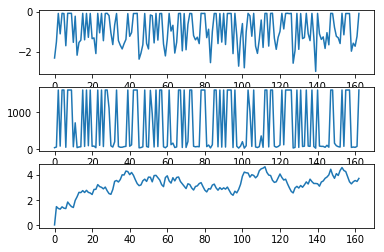

In [182]:
plt.figure(1)
plt.subplot(311)
plt.plot(avg_reward_per_episode)
plt.subplot(312)
plt.plot(num_step_per_episode)
plt.subplot(313)
plt.plot(avg_l1_V_weights_per_episode)
plt.show()

In [183]:
def checkout_actor(_actor):
    state = env.reset()
    ans = 0
    for step in count():
        act = _actor.cal(state)
        new_state, reward, done, _= env.step(act)
        env.render()
        if done:
            print("Episode %d [ACTOR] Finish after %d step" % (i_episode, step+1))
            print("-------------------------------------")
            ans = step + 1
            break
        # Move on 
        state = new_state
    return ans

checkout_actor(actor)

Episode 30 [ACTOR] Finish after 185 step
-------------------------------------


185

In [184]:
env.close()